# 2. Traditional ML models, trained using Staley's features.

Retraining ML model using just 6 features from Staley model (those available from USGS shapefiles):

-I15, total accumulation, storm duration, Area, PropHM23, dNBR1000, KF

In [50]:
import pandas as pd
pd.set_option("max_colwidth", 50)
import pickle
import numpy as np

In [51]:
trainX_all, trainY, testX_all, testY = pickle.load(open("staley16+addtl_feats_split.pkl","rb"))

Reduce to features from Staley's model only:

In [3]:
use_feats = [
    "stormdur_h",
    "stormaccum_mm",
    "peak_i15_mmh",
    "contributingarea_km2",
    "prophm23",
    "dnbr1000",
    "kf"]

trainX = trainX_all[use_feats]
testX = testX_all[use_feats]

In [15]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((982, 7), (261, 7), (982,), (261,))

In [5]:
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Function to get score for given classifier, and save into dataframe:

In [7]:
def get_scores(trues, probs):
    scores=[func(trues, np.round(probs[:,1])) for func in [accuracy_score, jaccard_score, f1_score]]
    scores.append(roc_auc_score(trues, probs[:,1]))
    return scores

def get_scoredf(TrTr, TrPr, TeTr, TePr):
    train_scores=get_scores(TrTr, TrPr)
    test_scores=get_scores(TeTr, TePr)
    
    scoredf=pd.DataFrame({"Training": train_scores, "Test": test_scores}, 
                         index=["Accurary", "Jaccard", "F1", "AUC"])
    return scoredf

In [8]:
select_criterion="entropy"
clfp=DecisionTreeClassifier(criterion=select_criterion, max_depth=9)
#merging train and validation dataset

clfp.fit(trainX, trainY)
trainYp=clfp.predict_proba(trainX)
testYp=clfp.predict_proba(testX)

scoredf_dt=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_dt

,Training,Test
Accurary,0.922607,0.846743
Jaccard,0.718519,0.420290
F1,0.836207,0.591837
AUC,0.979286,0.806332


Testing different ML models:

In [9]:
clfl = LogisticRegression(random_state=0, max_iter=10000).fit(trainX, trainY)
trainYp=clfl.predict_proba(trainX)
testYp=clfl.predict_proba(testX)

scoredf_lr=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_lr

,Training,Test
Accurary,0.793279,0.846743
Jaccard,0.349359,0.322034
F1,0.517815,0.487179
AUC,0.826930,0.857765


In [10]:
rfdpt=10
clff = RandomForestClassifier(max_depth=rfdpt, random_state=0, criterion="entropy")

clff.fit(trainX, trainY)
trainYp=clff.predict_proba(trainX)
testYp=clff.predict_proba(testX)

scoredf_rf=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_rf

,Training,Test
Accurary,0.991853,0.862069
Jaccard,0.969925,0.446154
F1,0.984733,0.617021
AUC,0.999810,0.907656


In [11]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

The models below benefit from scaling the features:

In [20]:
ssc=pickle.load(open("feature_scaler.pkl", "rb"))
trainX_s=pd.DataFrame(ssc.transform(trainX_all), columns=trainX_all.columns)[use_feats]
testX_s=pd.DataFrame(ssc.transform(testX_all), columns=testX_all.columns)[use_feats]

In [22]:
neigh = KNeighborsClassifier(n_neighbors=5, metric="euclidean", p=2)
neigh.fit(trainX_s, trainY);

trainYp=neigh.predict_proba(trainX_s)
testYp=neigh.predict_proba(testX_s)

scoredf_kn=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_kn

,Training,Test
Accurary,0.868635,0.842912
Jaccard,0.589172,0.414286
F1,0.741483,0.585859
AUC,0.935041,0.873775


In [23]:
clfs=SVC(gamma="auto", kernel="rbf", C=100, probability=True)
clfs.fit(trainX_s, trainY)

trainYp=clfs.predict_proba(trainX_s)
testYp=clfs.predict_proba(testX_s)

scoredf_svm=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_svm

,Training,Test
Accurary,0.918534,0.839080
Jaccard,0.711191,0.333333
F1,0.831224,0.500000
AUC,0.968508,0.810958


In [24]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [25]:
clfgb = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0, max_depth=3, random_state=0)
clfgb.fit(trainX, trainY)

trainYp=clfgb.predict_proba(trainX)
testYp=clfgb.predict_proba(testX)

scoredf_gb=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_gb

,Training,Test
Accurary,1.0,0.877395
Jaccard,1.0,0.522388
F1,1.0,0.686275
AUC,1.0,0.911103


In [26]:
clfab = AdaBoostClassifier(n_estimators=500, learning_rate=0.95, random_state=0)
clfab.fit(trainX, trainY)

trainYp=clfab.predict_proba(trainX)
testYp=clfab.predict_proba(testX)

scoredf_ab=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_ab

,Training,Test
Accurary,0.960285,0.835249
Jaccard,0.862191,0.385714
F1,0.925996,0.556701
AUC,0.994558,0.865385


In [27]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [28]:
mynb=GaussianNB()
mynb.fit(trainX, trainY)

trainYp=mynb.predict_proba(trainX)
testYp=mynb.predict_proba(testX)

scoredf_nb=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_nb

,Training,Test
Accurary,0.776986,0.831418
Jaccard,0.242215,0.266667
F1,0.389972,0.421053
AUC,0.786871,0.815040


In [29]:
mymix=GaussianMixture(n_components=2, init_params='kmeans', covariance_type='diag')
mymix.fit(trainX, trainY)

trainYp=mymix.predict_proba(trainX)
testYp=mymix.predict_proba(testX)

scoredf_gm=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_gm

,Training,Test
Accurary,0.320774,0.226054
Jaccard,0.226218,0.147679
F1,0.368969,0.257353
AUC,0.505349,0.464351


After studying the data files on the USGS debris flow emergency webpage, and trying to reproduce Staley's 
results, I'm sure he used the total rainfall accumulation over 15 minutes, rather than the hourly intensity.
The keyword argument toggle in this function fixes this now by default:

In [30]:
def staley16_lsprob(i15, PropHM, dNBR, KF, use_15min_accum=True):
    
    if use_15min_accum:
        cfact=4.
    else:
        cfact=1.
    PropHM_x_i15 = i15/cfact * PropHM
    dNBR_x_i15 = i15/cfact * dNBR
    KF_x_i15 = i15/cfact * KF
    
    beta = -3.61
    c1 = 0.41
    c2 = 0.67
    c3 = 0.70
    
    x = beta + c1*PropHM_x_i15 + c2*dNBR_x_i15 + c3*KF_x_i15
    
    #sigmoid function
    P=np.exp(x) /  (1. + np.exp(x))
    
    return P

In [31]:
trainYp=staley16_lsprob(trainX["peak_i15_mmh"], trainX["prophm23"], trainX["dnbr1000"], trainX["kf"])
testYp=staley16_lsprob(testX["peak_i15_mmh"], testX["prophm23"], testX["dnbr1000"], testX["kf"])

trainYpp=np.array([1.-trainYp, trainYp]).T
testYpp=np.array([1.-testYp, testYp]).T

scoredf_staley=get_scoredf(trainY, trainYpp, testY, testYpp)
scoredf_staley

,Training,Test
Accurary,0.757637,0.789272
Jaccard,0.394402,0.367816
F1,0.565693,0.537815
AUC,0.802810,0.790366


Merging the Jaccard score for the different classifiers into a single dataframe:

In [32]:
dfs={"Staley 2016": scoredf_staley,
     "Logistic Regression": scoredf_lr,
     "Decision Tree": scoredf_dt, 
     "Random Forest": scoredf_rf, 
     "K-nearest Neighbors": scoredf_kn,
     "Support Vector Machine": scoredf_svm,
     "Gradient Boosting": scoredf_gb,
     "AdaBoost": scoredf_ab,
     "Naive Bayes": scoredf_nb,
     "GaussianMixture": scoredf_gm}

In [33]:
trainsum=[dfs[key].loc["Jaccard","Training"] for key in dfs.keys()]
testsum=[dfs[key].loc["Jaccard","Test"] for key in dfs.keys()]

sumdf=pd.DataFrame({"Training": trainsum, "Testing": testsum}, index=dfs.keys())
sumdf

,Training,Testing
Staley 2016,0.394402,0.367816
Logistic Regression,0.349359,0.322034
Decision Tree,0.718519,0.420290
Random Forest,0.969925,0.446154
K-nearest Neighbors,0.589172,0.414286
Support Vector Machine,0.711191,0.333333
Gradient Boosting,1.000000,0.522388
AdaBoost,0.862191,0.385714
Naive Bayes,0.242215,0.266667
GaussianMixture,0.226218,0.147679


In [34]:
sumdf["Testing"].mean()

0.36263610760814247

In [35]:
from sklearn.metrics import roc_curve, RocCurveDisplay

In [36]:
models={"Staley (2016)": testYpp[:,1],
        "Logistic Regression": clfl,
        #"Decision Tree": clfp,
        "Random Forest": clff,
        "K-Nearest Neighbors": neigh,
        "SVC": clfs,
        "Gradient Boosting": clfgb,
        #"Adaboost": clfab,
        "Naive Bayes": mynb}

In [37]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

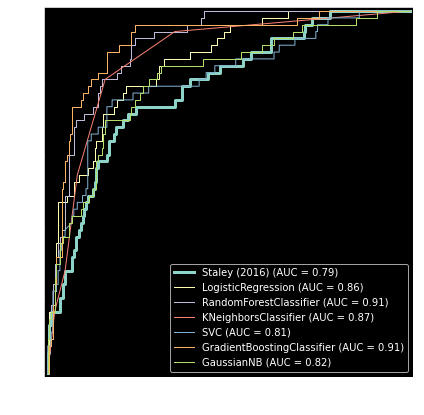

In [38]:
fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(left=0.125, bottom=0.1, top=0.98, right=0.98)

def compare_rocs(models, ax):
    
    for modelkind in models.keys():
        if type(models[modelkind]).__name__ not in  ['Series','ndarray']:
            
            if type(models[modelkind]).__name__ in ['SVC', 'KNeighborsClassifier']:
                RocCurveDisplay.from_estimator(models[modelkind], testX_s, testY, ax=ax,
                                              linewidth=1)
            else:
                RocCurveDisplay.from_estimator(models[modelkind], testX, testY, ax=ax,
                                              linewidth=1)
        else:
            RocCurveDisplay.from_predictions(testY, models[modelkind], ax=ax, name=modelkind,
                                            linewidth=3)
                
    ax.set_aspect('equal')
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    
compare_rocs(models, ax)
fig.savefig("roc_totaccum_addl_features_randn.png", dpi=300)

This code saves the predictions for each classifier into subdirectory.  These will be used to plot up ROC curves obtained using different features against each other:

In [53]:
from os.path import isdir
from posix import mkdir 

odir="minpars_accum_randn"

if not isdir(odir):
    mkdir(odir)

In [54]:
import pickle

In [41]:
for key in models.keys():
    
    if type(models[key]).__name__ != 'ndarray':
        if type(models[key]).__name__ in ['SVC', 'KNeighborsClassifier']:
            testY_proba=models[key].predict_proba(testX_s)
        else:
            testY_proba=models[key].predict_proba(testX)
    else:
        testY_proba=models[key]
        
    outfile=odir + '/' + key + '_proba.pkl'
    pickle.dump(testY_proba, open(outfile, "wb"))

In [42]:
!ls -l $odir

total 52
-rw-r--r-- 1 droten droten 4329 Mar 16 22:13 'Gradient Boosting_proba.pkl'
-rw-r--r-- 1 droten droten 4329 Mar 16 22:13 'K-Nearest Neighbors_proba.pkl'
-rw-r--r-- 1 droten droten 4329 Mar 16 22:13 'Logistic Regression_proba.pkl'
-rw-r--r-- 1 droten droten 4329 Mar 16 22:13 'Naive Bayes_proba.pkl'
-rw-r--r-- 1 droten droten 4329 Mar 16 22:13 'Random Forest_proba.pkl'
-rw-r--r-- 1 droten droten 4329 Mar 16 22:13  SVC_proba.pkl
-rw-r--r-- 1 droten droten 2239 Mar 16 22:13 'Staley (2016)_proba.pkl'


In [43]:
pickle.dump(testY, open(f"{odir}/testY.pkl", "wb"))

From [diagnostic test assessment](https://www.sciencedirect.com/science/article/pii/S1556086415306043):

"AUC is an effective way to summarize the overall diagnostic accuracy of the test. It takes values from 0 to 1, where a value of 0 indicates a perfectly inaccurate test and a value of 1 reflects a perfectly accurate test. AUC can be computed using the trapezoidal rule. In general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding."

Merge training and testing data, and re-train:

In [45]:
traintestX = pd.concat([trainX, testX])
traintestY = pd.concat([trainY, testY])

traintestX.shape, traintestY.shape

((1243, 7), (1243,))

Save trained classifier.  It will be re-used for making predictions on new cases:

In [49]:
clffp = RandomForestClassifier(max_depth=rfdpt, random_state=0, criterion="gini")
clffp.fit(traintestX, traintestY)
pickle.dump(clffp, open("Random_forest_classifier_basefeats.pkl", "wb"))